# Humanitarian Aid Allocation Using Clustering and PCA



<div style="display: flex;">
  <div style="flex: 2;">
    <p>
      Objective:
Identify high-priority countries for humanitarian aid allocation using socioeconomic indicators
and unsupervised machine learning (PCA + KMeans).
    </p>
   <p>
   The dataset contains the following features:

* country — name of the country;
* child_mort — under-five child mortality rate;
* exports — exports per capita;
* health — healthcare expenditure per capita;
* imports — imports per capita;
* Income — average income per capita;
* Inflation — annual inflation rate;
* life_expec — average life expectancy;
* total_fer — total fertility rate;
* gdpp — GDP per capita.
   </p>
  </div>
  <div style="flex: 1;">
    <img src="assets/img1.jpg" alt="Image description" style="width:50%;">
    <p style="text-align: center; font-size: small;">Image source</p>
  </div>
</div>


In [2]:
# --- 1. Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [3]:

# --- 2. Load and Inspect Data ---
data = pd.read_csv('data/Country-data.csv')
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [4]:
# --- 3. Data Preprocessing ---
features = data.columns.drop('country')
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

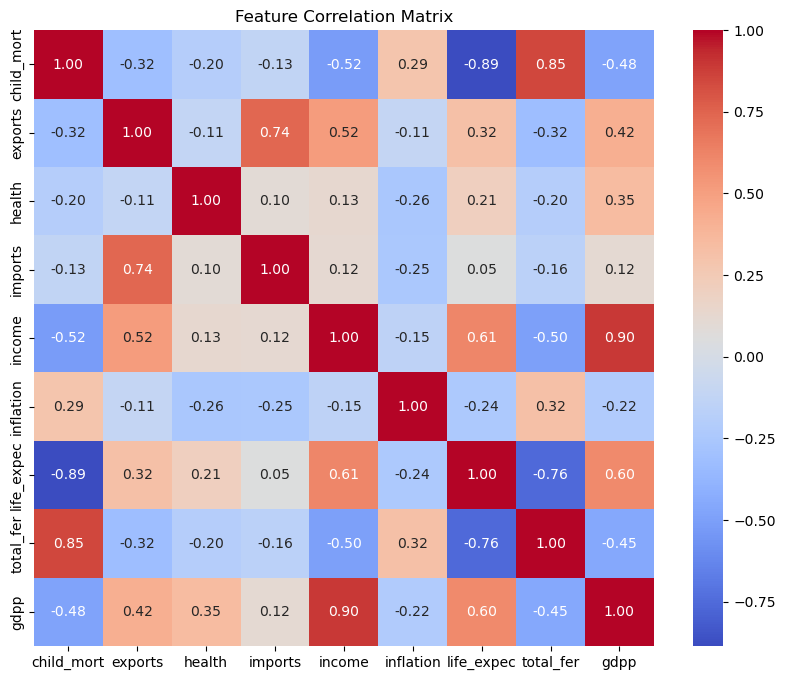

In [5]:
# --- 4. Exploratory Data Analysis (EDA) ---
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(data[features].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

This heatmap shows the relationships between all features in the dataset.
Strong positive correlations are observed between:

Income and GDP per capita (gdpp)
Life expectancy and income
Child mortality and total fertility rate (negatively correlated with life expectancy)
These correlations suggest redundancy, which validates the use of dimensionality reduction like PCA.

In [6]:

# --- 5. Dimensionality Reduction with PCA ---
pca = PCA()
pca.fit(data[features])
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
num_components = np.argmax(cumulative_variance >= 0.90) + 1

In [14]:
num_components

5

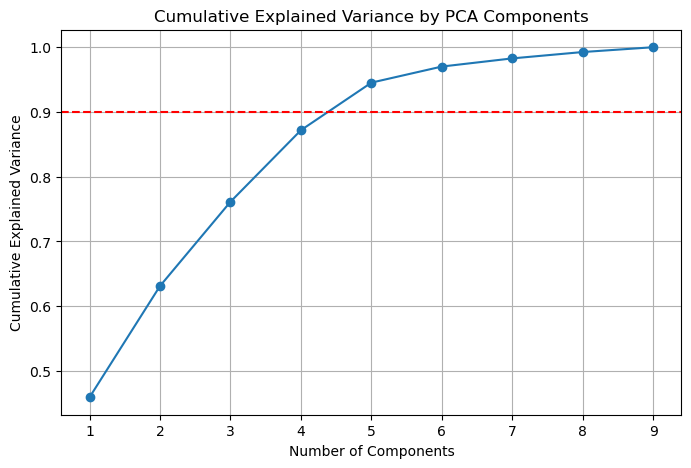

In [7]:
# Scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.axhline(y=0.90, color='r', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


The scree plot displays cumulative explained variance by the number of principal components.
The first 5 components explain more than 90% of the variance, justifying the reduction from 9 features to 5 dimensions without significant information loss.

In [8]:
# Transform data
pca_transformed_df = pd.DataFrame(pca.transform(data[features]))

In [9]:
# --- 6. Clustering with KMeans ---
cluster_range = range(2, 11)
best_score = -1
best_n_clusters = 0

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=1)
    labels = kmeans.fit_predict(pca_transformed_df)
    score = silhouette_score(pca_transformed_df, labels)
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters
        
        
        
# Final model with optimal clusters
kmeans = KMeans(n_clusters=best_n_clusters, init='k-means++', random_state=1)
data['cluster'] = kmeans.fit_predict(pca_transformed_df)

c:\Users\mazur\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\mazur\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\mazur\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\mazur\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

In [20]:
print(best_score)

print(best_n_clusters)

0.2873566892140671
2


In [10]:
# --- 7. Insights & Country Selection ---
# Identify vulnerable cluster
max_child_mort_cluster = data.loc[data['child_mort'].idxmax(), 'cluster']
min_gdpp_cluster = data.loc[data['gdpp'].idxmin(), 'cluster']
target_cluster = max_child_mort_cluster  # assuming both are equal

In [11]:
# Select target countries
target_countries = data[data['cluster'] == target_cluster]
selected = target_countries.nsmallest(3, 'life_expec')


In [12]:
# Output selected countries
selected_countries = selected['country'].values
print("Countries recommended for humanitarian aid:", selected_countries)

Countries recommended for humanitarian aid: ['Haiti' 'Lesotho' 'Central African Republic']


C:\Users\mazur\AppData\Local\Temp\ipykernel_17360\1711516304.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pca_2d['cluster'] = data['cluster']


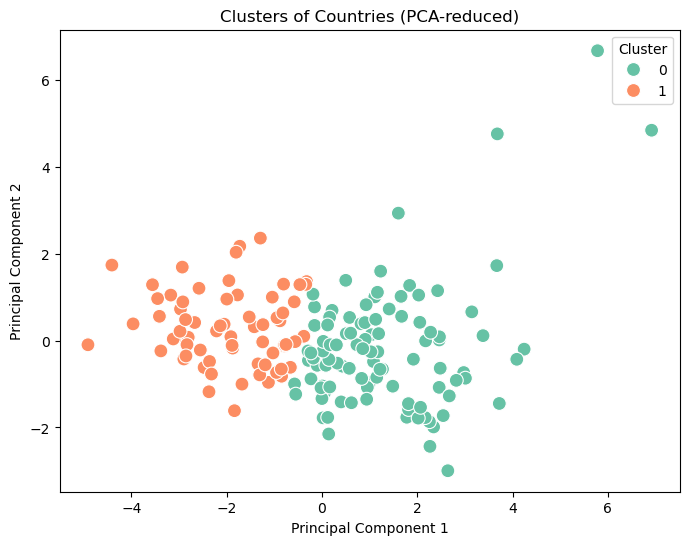

In [13]:
# --- 8. Visualization of Clusters ---
pca_2d = pca_transformed_df.iloc[:, :2]
pca_2d.columns = ['PC1', 'PC2']
pca_2d['cluster'] = data['cluster']

plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_2d, x='PC1', y='PC2', hue='cluster', palette='Set2', s=100)
plt.title('Clusters of Countries (PCA-reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


This scatter plot shows countries in the space of the first two principal components, colored by their assigned clusters from KMeans.

Distinct clusters are visible, suggesting the algorithm found meaningful structure in the data.
One cluster contains the most vulnerable countries based on low life expectancy and GDP, and high child mortality.

# --- 9. Summary ---
"""
- Optimal number of clusters: **2**
- Principal components explain >90% variance in **5** dimensions

- Top 3 countries most in need (low life expectancy, high mortality, low GDP):
**'Haiti' 'Lesotho' 'Central African Republic'**
"""


# Final Conclusion
This project used PCA and KMeans clustering to identify groups of countries with similar socioeconomic conditions, supporting a data-driven approach to humanitarian aid allocation.

Key insights:

The optimal number of clusters (based on silhouette score) was automatically selected.
Countries with high child mortality, low income, and low life expectancy were grouped together.
The three most at-risk countries, based on these indicators, were identified for prioritized aid.
✅ This pipeline enables humanitarian organizations to make informed, scalable, and fair funding decisions — transforming complex global indicators into actionable insights.

